# Importando los paquetes que vamos a usar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from time import time

# Algoritmos de clusterizacion
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering

# Para reducir dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Metricas de los clusters
from sklearn import metrics
from sklearn.metrics import pairwise_distances

# Para la anotacion de tipos
from typing import Callable, List, Dict, Tuple

# Carga de los datos

In [2]:
base_path = "dataset/datos_hogar_2020.csv"
df_global = pd.read_csv(base_path)

# Funciones comunes a todos los casos de estudio

Definimos en esta sección las funciones que vamos a usar a lo largo de todos los casos de estudio:

In [3]:
def drop_columns(df: pd.DataFrame, exclude_columns: List[str] = None) -> pd.DataFrame:
    """
    Dada una lista con columnas a excluir, devuelve un nuevo dataframe en el que 
    hemos quitado estas columnas. Si exclude_columns es None, no se hace nada.
    
    En ningun caso se modifica df, se hace una copia de este y se opera con 
    dicha copia
    """
    
    # Hacemos una copia del dataframe
    df_filtered = df.copy()
    
    # Excluimos las columnas en caso de que se haya pasado una lista no None
    if exclude_columns is not None:
        df_filtered = df_filtered.drop(columns = exclude_columns)
    
    # Devolvemos el dataframe copia filtrado
    return df_filtered

## Decorador para tomar el tiempo de ejecución de una función

In [4]:
def time_func(func):
    """
    Decorador que toma una funcion func -> result y devuelve una funcion 
    func' -> result, ellapsed
    """
    
    # Definimos la funcion modificada como hemos especificado en la documentacion
    def modified_function(*args, **kwargs):
        init = time()
        result = func(*args, **kwargs)
        end = time()
        
        # Devolvemos el resultado junto con el tiempo que tardo en ejecutarse
        return result, end - init
    
    return modified_function

## Funciones para calcular clusters

In [5]:
@time_func
def compute_kmeans(df: pd.DataFrame, number_clusters: int = 3) -> np.array:
    """
    Dado un dataframe con los datos a clusterizar, calcula el vector con las
    etiquetas de la clusterizacion kmeans
    """
    
    kmeans = KMeans(n_clusters = number_clusters, random_state=0).fit(df)
    return kmeans.labels_

@time_func
def compute_dbscan(df: pd.DataFrame, eps: float = 0.3, min_samples: int = 10) -> np.array:
    """
    Dado un dataframe con los datos a clusterizar, calcula el vector con las
    etiquetas de la clusterizacion dbscan
    """
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
    return db.labels_

@time_func
def compute_birch(df: pd.DataFrame, num_clusters: int = None) -> np.array:
    """
    Dado un dataframe con los datos a clusterizar, calcula el vector con las
    etiquetas de la clusterizacion birch
    """
    
    brc = Birch(n_clusters=num_clusters)
    brc.fit(df)
    return brc.labels_

@time_func
def compute_mean_shift(df: pd.DataFrame, bandwidth: float = 2.0, max_iter: int = 300) -> np.array:
    """
    Dado un dataframe con los datos a clusterizar, calcula el vector con las
    etiquetas de la clusterizacion Mean Shift
    """

    clustering = MeanShift(bandwidth=bandwidth, max_iter = max_iter).fit(df)
    return clustering.labels_

@time_func
def compute_agglomerative_clustering(df: pd.DataFrame, n_clusters: int = None, linkage: str = "ward") -> np.array:
    """
    Dado un dataframe con los datos a clusterizar, calcula el vector con las
    etiquetas de la clusterizacion de forma jerarquica
    """
    
    clustering = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage).fit(df)
    return clustering.labels_

def add_clustering_labels(df: pd.DataFrame, clustering_function: Callable, parameters: dict(), new_label_name: str, exclude_columns: List[str] = None) -> Tuple[pd.DataFrame, float]:
    """
    Dado un dataframe y un algoritmo de clusterizacion con sus parametros, devuelve el dataframe al que
    hemos añadido una columna con las nuevas etiquetas del clustering. Con esto nos evitamos escribir
    esta funcion para cada tipo de algorito para clusterizar. Solo tenemos que cambiar ese parametro
    
    Podemos excluir columnas para que no se usen en la clusterizacion
    
    Devuelve un dataframe con la nueva columna de etiquetas añadida y con el tiempo que tardo en ejecutarse
    """
    
    # Filtramos las columnas del dataframe que se quieren exluir del computo
    df_filtered = drop_columns(df, exclude_columns)
    
    # Realizamos el calculo
    # Todas las funciones que calculan clusters llevan el decorador @time_func 
    # y por tanto devuelven cuanto tiempo an tardado 
    labels, ellapsed = clustering_function(df_filtered, **parameters)

    # Añadimos las etiquetas a la vez que recuperamos las columnas eliminadas
    new_df = df.copy()
    new_df[new_label_name] = labels
    
    return new_df, ellapsed

## Funciones para evaluar clusters

In [6]:
def metric_silhouette(df: pd.DataFrame, labels: np.array, exclude_columns: List[str] = None) -> float:
    """Calcula el indice de silhouette de una clusterizacion"""
    
    # Excluimos las columnas si se ha especificado asi por parametro
    df_filtered = drop_columns(df, exclude_columns)
    
    # Devolvemos la metrica buscada
    return metrics.silhouette_score(df_filtered, labels, metric='euclidean')

def metric_calinski(df: pd.DataFrame, labels: np.array, exclude_columns: List[str] = None) -> float:
    """Calcula el indice de Calinski-Harabasz de una clusterizacion"""
    
    # Excluimos las columnas si se ha especificado asi por parametro
    df_filtered = drop_columns(df, exclude_columns)
    
    # Devolvemos la metrica buscada
    return metrics.calinski_harabasz_score(df_filtered, labels)

def metric_davies_bouldin(df: pd.DataFrame, labels: np.array, exclude_columns: List[str] = None) -> float:
    """Calcula el indice de Davies-Bouldin de una clusterizacion"""
    
    # Excluimos las columnas si se ha especificado asi por parametro
    df_filtered = drop_columns(df, exclude_columns)
    
    # Devolvemos la metrica buscada
    return metrics.davies_bouldin_score(df_filtered, labels)

def metric_elements_in_each_cluster(labels: np.array) -> Tuple[float, float]:
    """Calcula el numero medio de elementos por cada cluster, y la desviacion tipica del
    numero de elementos por cada cluster"""
    
    # Tomamos los valores unicos en el conjunto de etiquetas
    # Esto nos da las etiquetas de los clusters que hemos construido
    cluster_labels = set(labels)
    
    # Calculamos el numero de elementos que hay en cada cluster
    elements_in_each_cluster = []
    
    for label in cluster_labels:
        curr_labels = [el for el in labels if el == label]
        elements_in_each_cluster.append(len(curr_labels))
    
    
    # Calculamos las estadisticas usando numpy
    elements_in_each_cluster = np.array(elements_in_each_cluster)
    mean = np.mean(elements_in_each_cluster)
    std = np.std(elements_in_each_cluster)
    
    return mean, std

def metric_total_clusters(labels: np.array) -> int:
    """Calcula el numero total de clusters que hemos generado con un algoritmo"""
    
    # Tomamos los valores unicos en el conjunto de etiquetas
    # Esto nos da las etiquetas de los clusters que hemos construido
    cluster_labels = set(labels)
    
    # Con esto, solo tenemos que devolver el tamaño de dicho conjunto
    return len(cluster_labels)
    
def compute_clustering_metrics(df: pd.DataFrame, labels: np.array) -> Dict[str, float]:
    """
    Computa todas las metricas que tenemos sobre un clustering.
    
    @param df el dataframe, con solo los datos de entrada (quitar etiquetas y otros metadatos)
    @param labels las etiquetas obtenidas en un proceso de clustering
    
    @return metrics diccionario con pares "nombre_metrica": valor_metrica 
    """
               
    # Aplicamos todos los computos necesarios
    silhouette = metric_silhouette(df, labels)
    calinski = metric_calinski(df, labels)
    davies = metric_davies_bouldin(df, labels)
    total_clusters = metric_total_clusters(labels)
    elements_mean, elements_std = metric_elements_in_each_cluster(labels)
    
    # Devolvemos todas las metricas en un diccionario
    metrics = dict()
    metrics["silhouette"] = silhouette
    metrics["calinski"] = calinski
    metrics["davies"] = davies
    metrics["total_clusters"] = total_clusters
    metrics["elements_mean"] = elements_mean
    metrics["elements_std"] = elements_std
    
    return metrics

## Funciones para realizar visualizaciones

In [7]:
def custom_pair_plot(df: pd.DataFrame, hue: str = None, exclude_columns: List[str] = None):
    """
    Muestra una grafica pairplot de seaborn. Podemos especificar una lista de
    columnas que exluir de esta grafica de forma comoda
    """
    df_filtered = df.copy()
    if exclude_columns is not None:
        df_filtered = df_filtered.drop(columns = exclude_columns)
        
    sns.pairplot(df_filtered, hue = hue)

# Filtrado previo del dataset global

Definimos en variables todas las columnas que, al leer el documento explicando el *dataset*, nos han resultado de interés. Una vez hecho esto, filtramos el *dataset* global para quedarnos solo con esas columnas, pues el resto no las vamos a usar en ningún caso de estudio. Es más, muchas de estas columnas no las usaremos en ninguno de los tres casos de estudio.

In [8]:
# Definimos las columnas con las que nos vamos a quedar
renta_disponible_total_hogar = "HY020"
renta_ganada_alquilando = "HY040N"
ayuda_para_vivienda = "HY070N"
inversiones_de_capital = "HY090N"
retraso_pago_hipoteca_o_alquiler = "HS011"
retraso_pago_luz_agua_gas = "HS021"
retraso_pago_prestamos = "HS031"
capacidad_hogar_llegar_fin_mes = "HS120"
ingresos_minimos_para_llegar_fin_mes = "HS130"
vandalismo_en_la_zona = "HS190"
comunidad_autonoma = "DB040"

tipo_de_vivienda = "HH010"
regimen_de_tenencia_vivienda = "HH021"
habitaciones_vivienda = "HH030"

pidio_ayuda_economica_familiares = "H39A_U"
pidio_ayuda_economica_entidad = "H39B_U"
corte_energia = "H38A_U"

numero_miembros_hogar = "HX040"
tipo_de_hogar = "HX060" # Variable numerica categorica con muchos valores posibles
hogar_en_riesgo_pobreza = "vhPobreza"
hogar_carencia_material_severa = "vhMATDEP"

proposito_prestamos = lambda i: f"HI100_{i}"

cuota_hipoteca = "cuotahip"

# TODO -- estas variables no las tenemos disponibles en el dataset
#gasto_en_comida = "HC010"
#gasto_en_comida_bebida_fuera_casa = "HC020"
#gasto_transporte_publico = "HC030"
#gasto_transporte_privado = "HC040"
#viviendas_adicionales = "HV020"
#año_nacimiento = "PB140"
#sexo = "PB150"

# Filtramos todo el dataframe global para usar solo variables que en una primera
# lectura de las variables hemos considerado interesantes
df_global = df_global[[
    renta_disponible_total_hogar,
    renta_ganada_alquilando,
    ayuda_para_vivienda,
    inversiones_de_capital,
    retraso_pago_hipoteca_o_alquiler,
    retraso_pago_luz_agua_gas,
    retraso_pago_prestamos,
    capacidad_hogar_llegar_fin_mes,
    ingresos_minimos_para_llegar_fin_mes,
    vandalismo_en_la_zona,
    tipo_de_vivienda,
    regimen_de_tenencia_vivienda,
    habitaciones_vivienda,   
    pidio_ayuda_economica_familiares,
    pidio_ayuda_economica_entidad,
    corte_energia,
    numero_miembros_hogar,
    tipo_de_hogar,
    hogar_en_riesgo_pobreza,
    hogar_carencia_material_severa,
    comunidad_autonoma,


    
    # TODO -- borrar los propositos porque no parecen muy relevantes
    proposito_prestamos(1),
    proposito_prestamos(2),
    proposito_prestamos(3),
    proposito_prestamos(4),
    proposito_prestamos(5),
    proposito_prestamos(6),
    proposito_prestamos(7),
    proposito_prestamos(8),
    proposito_prestamos(9),  
    
    cuota_hipoteca,
]]

Veamos con qué tipo de datos nos hemos quedado:

In [9]:
df_global.describe()

,HY020,HY040N,HY070N,HY090N,HS011,HS021,HS031,HS120,HS130,HS190,...,HI100_1,HI100_2,HI100_3,HI100_4,HI100_5,HI100_6,HI100_7,HI100_8,HI100_9,cuotahip
count,15043.000000,15043.000000,15043.000000,15043.000000,6538.000000,14972.000000,3874.000000,15029.000000,14577.000000,15036.000000,...,3907.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3905.000000,3905.000000,3949.000000
mean,31923.953455,597.200527,44.600766,439.817903,2.858978,2.911969,2.864481,3.600905,1863.563628,1.861599,...,1.741234,1.536354,1.988223,1.934460,1.975678,1.903226,1.937532,1.978745,1.820743,472.389466
std,22626.484550,2487.349778,489.955873,3229.657848,0.420883,0.336180,0.411509,1.277720,1052.184371,0.345332,...,0.438013,0.498740,0.107894,0.247508,0.154065,0.295688,0.242035,0.144251,0.383617,278.946452
min,-36233.200000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,16505.950000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,1200.000000,2.000000,...,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,300.000000
50%,27535.710000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,4.000000,1600.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,412.000000
75%,41390.350000,0.000000,0.000000,31.800000,3.000000,3.000000,3.000000,5.000000,2200.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,580.000000
max,349862.130000,70271.000000,21600.000000,95460.200000,3.000000,3.000000,3.000000,6.000000,60000.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,6800.000000


# Variables añadidas

También queremos usar variables agregadas usando las variables en bruto que ya tenemos en el dataset. 

Tenemos tres tipos de variable que nos indican si pidieron ayuda a algún ente, divididas en tres tipos de ente. Nos interesa solo si pidieron ayuda, no a quién

In [10]:
def pidio_ayuda_condicion(ayuda_familiar, ayuda_entidad):
    """Comprueba si, dadas las columnas de ayuda familiar y ayuda de entidad,
    se pidio ayuda o no se pidio"""
    
    if ayuda_familiar == 1 or ayuda_entidad == 1:
        return True
    else:
        return False



# Añadimos la nueva columna usando la condicion que hemos definido previamente
pidio_ayuda = "pidio_ayuda"
df_global[pidio_ayuda] = df_global.apply(lambda row: pidio_ayuda_condicion(row[pidio_ayuda_economica_familiares], row[pidio_ayuda_economica_entidad]), axis = 1)

Queremos tener una variable en la que dispongamos del dinero que le queda a una familia, de la forma $total\_ingresos - total\_gastos$ 

In [11]:
# TODO -- implementar esto

Añadimos una variable que recoja si ha habido retraso en cualquier tipo de pago:

In [12]:
def retraso_pagando(retraso_hipoteca, retraso_luz_agua, retraso_prestamos):
    """Comprueba si hubo algun retraso en cualquier tipo de pago"""
    
    # Hubo retraso en la hipoteca
    if retraso_hipoteca is not None and retraso_hipoteca != 3:
        return 1
    
    # Hubo retraso en la luz o el agua
    if retraso_luz_agua is not None and retraso_luz_agua != 3:
        return 1
    
    # Hubo retraso en algun prestamo
    if retraso_prestamos is not None and retraso_prestamos != 3:
        return 1

    # No hubo retraso en ningun apartado
    return 0


# Añadimos la nueva columna usando la condicion que hemos definido previamente
retraso_pago = "retraso_pago"
df_global[retraso_pago] = df_global.apply(lambda row: retraso_pagando(row[retraso_pago_hipoteca_o_alquiler], row[retraso_pago_luz_agua_gas], row[retraso_pago_prestamos]), axis = 1)

Añadimos el nombre real de las comunidades autonomas:

In [13]:
def map_nombre_comunidad(code_name):
    """Transformamos el codigo de la comunidad autonoma a su nombre real"""
    map_code_to_name = {
        "ES11": "Galicia", 
        "ES12": "Principado de Asturias" , 
        "ES13": "Cantabria" , 
        "ES21": "País Vasco" , 
        "ES22": "Comunidad Foral de Navarra" , 
        "ES23": "La Rioja" , 
        "ES24": "Aragón" , 
        "ES30": "Madrid" , 
        "ES41": "Castilla y Leon" , 
        "ES42": "Castilla-La Mancha" , 
        "ES43": "Extremadura", 
        "ES51": "Cataluña" , 
        "ES52": "Comunidad Valenciana" , 
        "ES53": "Illes Balears" , 
        "ES61": "Andalucía" , 
        "ES62": "Región de Murcia" , 
        "ES63": "Ceuta" , 
        "ES64": "Melilla" , 
        "ES70": "Canarias" , 
        "ESZZ": "Externo" , 
    }
    
    return map_code_to_name[code_name]

df_global[comunidad_autonoma] = df_global.apply(lambda row: map_nombre_comunidad(row[comunidad_autonoma]), axis = 1)

# Caso de estudio 01

## Definición del caso de estudio

En este caso de estudio queremos poner nuestra atención en aquellas personas que tuvieron algún retraso en cualquier tipo de pago. Usamos la variable que hemos definido previamente como agregado de los dos tipos de *retraso en el pago*.

In [14]:
# Tomamos los datos de aquellos hogares que pidieron ayuda economica
df_first = df_global[df_global[retraso_pago] == 1]

# Nos quedamos con las columnas que nos interesan para este caso de estudio
columnas_interesantes = [
    renta_disponible_total_hogar,
    #ayuda_para_vivienda,
    #vandalismo_en_la_zona,
    #comunidad_autonoma,
    ingresos_minimos_para_llegar_fin_mes,
]
df_first = df_first[columnas_interesantes]

# Renombramos algunas columnas
df_first = df_first.rename(columns = {
    renta_disponible_total_hogar: "renta_disponible_hogar",
    #ayuda_para_vivienda: "ayuda_para_vivienda",
    #vandalismo_en_la_zona: "vandalismo_en_la_zona",
    #comunidad_autonoma: "comunidad_autonoma",
    ingresos_minimos_para_llegar_fin_mes: "ingresos_minimos_para_llegar_fin_mes"
})

## Preprocesado de los datos

Ahora que hemos seleccionado las variables, borramos aquellas filas en las que tengamos algún valor NaN:

In [15]:
df_first = df_first.dropna()

## Análisis exploratorio de datos

Antes de comenzar con el cálculo de *clusters*, realizamos un análisis exploratorio de datos previo. Empezamos mostrando las gráficas entre las variables con las que trabajamos, dos a dos. 

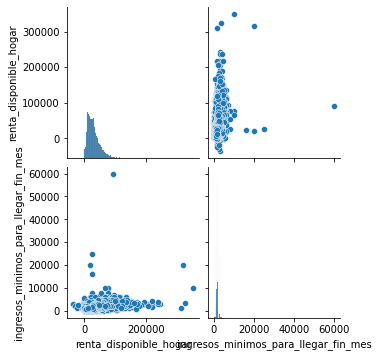

In [16]:
sns.pairplot(df_first)

## Aplicamos algoritmos de clustering

En todos los algoritmos estamos calculando los tiempos que tardan en ejecutarse. Esto lo guardaremos en el siguiente diccionario:

In [17]:
ellapsed_times = dict()

Empezamos aplicando el algoritmo `k-means`:

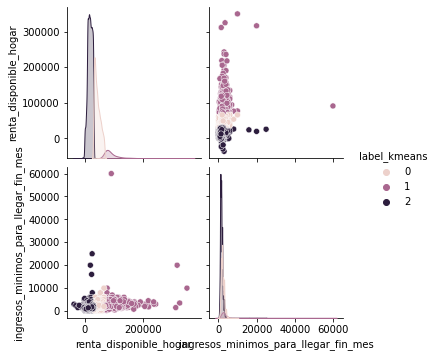

In [18]:
df_first, ellapsed = add_clustering_labels(
    df_first,
    compute_kmeans, 
    parameters = {"number_clusters": 3},
    new_label_name = "label_kmeans"
)

# Añado el tiempo consumido
ellapsed_times["label_kmeans"] = ellapsed

custom_pair_plot(df_first, hue = "label_kmeans")

Ahora aplicamos `dbscan` para la clusterización:

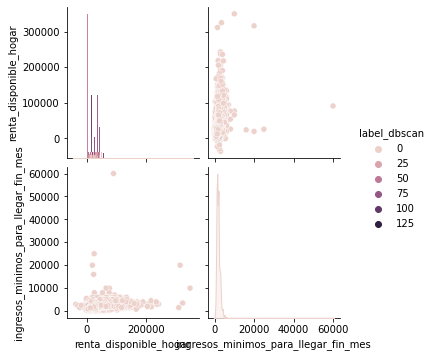

In [19]:
df_first, ellapsed = add_clustering_labels(
    df_first,
    compute_dbscan,
    parameters = {"eps": 0.3, "min_samples": 2},
    new_label_name = "label_dbscan",
    exclude_columns = ["label_kmeans"]
) 

# Añado el tiempo consumido
ellapsed_times["label_dbscan"] = ellapsed

custom_pair_plot(
    df = df_first,
    hue = "label_dbscan",
    exclude_columns = ["label_kmeans"]
)

Ahora aplicamos `birch`:

/home/sergio/.local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  warnings.warn(


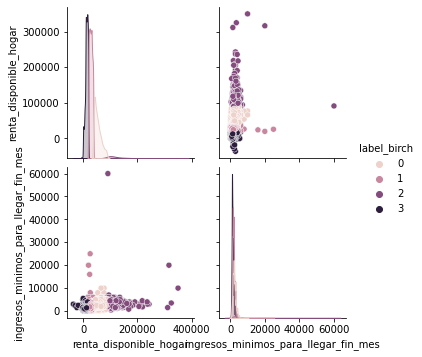

In [20]:
# TODO -- probar con num_clusters = None que es lo que pone en la pagina de ejemplo
# TODO -- quite eso porque tardaba demasiado
df_first, ellapsed = add_clustering_labels(
    df_first,
    compute_birch,
    parameters = {"num_clusters": 4},
    new_label_name = "label_birch",
    exclude_columns = ["label_kmeans", "label_dbscan"]
) 

# Añado el tiempo consumido
ellapsed_times["label_birch"] = ellapsed

custom_pair_plot(
    df = df_first,
    hue = "label_birch",
    exclude_columns = ["label_kmeans", "label_dbscan"]
)

Ahora aplicamos *Mean Shift*

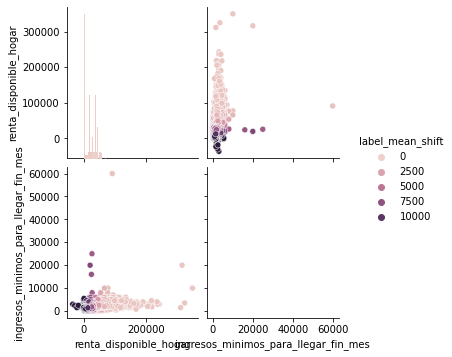

In [21]:
df_first, ellapsed = add_clustering_labels(
    df_first,
    compute_mean_shift,
    parameters = {"bandwidth": 2.0, "max_iter": 500},
    new_label_name = "label_mean_shift",
    exclude_columns = ["label_kmeans", "label_dbscan", "label_birch"]
) 

# Añado el tiempo consumido
ellapsed_times["label_mean_shift"] = ellapsed

custom_pair_plot(
    df = df_first,
    hue = "label_mean_shift",
    exclude_columns = ["label_kmeans", "label_dbscan", "label_birch"]
)

Ahora aplicamos *clustering* jerárquico:

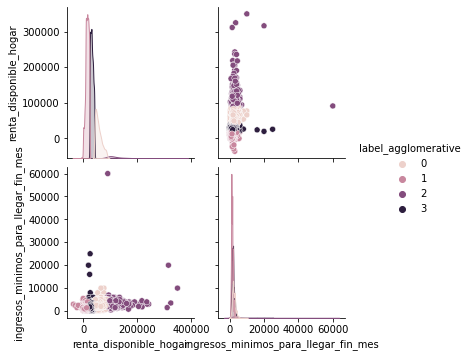

In [22]:
df_first, ellapsed = add_clustering_labels(
    df_first,
    compute_agglomerative_clustering,
    parameters = {"n_clusters": 4, "linkage": "ward"},
    new_label_name = "label_agglomerative",
    exclude_columns = ["label_kmeans", "label_dbscan", "label_birch", "label_mean_shift"]
) 

# Añado el tiempo consumido
ellapsed_times["label_agglomerative"] = ellapsed

custom_pair_plot(
    df = df_first,
    hue = "label_agglomerative",
    exclude_columns = ["label_kmeans", "label_dbscan", "label_birch", "label_mean_shift"]
)

## Métricas de las clusterizaciones

Una vez que hemos aplicado los cinco algoritmos anteriores, recogemos las métricas de cada algoritmo para poder compararlas:

In [23]:
# Todas las metricas que hemos construido
labels = ["label_kmeans", "label_dbscan", "label_birch", "label_mean_shift", "label_agglomerative"]

# Dataframe sin las columnas con las metricas
df_raw = drop_columns(df_first, labels)

# Diccionario que vamos a construir agregando todas las metricas
global_metrics = dict()

# Iteramos sobre cada una de las metricas
for label in labels:
    print(label)
    print("=" * 80)
    print("")
    
    # Tomamos las etiquetas del algoritmo actual y calculamos las metricas+
    curr_labels = df_first[label]
    curr_metrics = compute_clustering_metrics(df_raw, curr_labels)
    
    # Añadimos el tiempo de ejecucion para que se muestre con el resto de metricas
    curr_metrics["ellapsed_time (s)"] = ellapsed_times[label]
    
    # Mostramos dichas metricas
    pprint(curr_metrics)
    print("")
    print("")
    
    # Guardamos el diccionario con metricas en el nuevo diccionario con todas las metricas
    global_metrics[label] = curr_metrics

label_kmeans

{'calinski': 18752.57747390787,
 'davies': 0.5873941308994697,
 'elements_mean': 4288.666666666667,
 'elements_std': 2787.3753883457384,
 'ellapsed_time (s)': 1.1851990222930908,
 'silhouette': 0.5631186009849776,
 'total_clusters': 3}


label_dbscan

{'calinski': 1.569981359691632,
 'davies': 3.7368965621207657,
 'elements_mean': 100.515625,
 'elements_std': 1107.2870561673967,
 'ellapsed_time (s)': 0.07954597473144531,
 'silhouette': -0.8888227931560448,
 'total_clusters': 128}


label_birch

{'calinski': 19637.643111024714,
 'davies': 0.5615265842496409,
 'elements_mean': 3216.5,
 'elements_std': 1821.6372443491596,
 'ellapsed_time (s)': 8.967334508895874,
 'silhouette': 0.520005321321041,
 'total_clusters': 4}


label_mean_shift

{'calinski': 703475384.8883846,
 'davies': 0.011051617984279982,
 'elements_mean': 1.0586686414876985,
 'elements_std': 0.30073954466986474,
 'ellapsed_time (s)': 20.293120622634888,
 'silhouette': 0.08849718143307618,
 'total_clusters': 1215

## Visualizando estas métricas

Vamos a mostrar gráficamente algunas de estas métricas de forma comparativa entre los algoritmos considerados. Nos basamos fuertemente en el diccionario con las métricas agregadas de distintos algoritmos para realizar estas visualizaciones. Empezamos comparando los tiempos de ejecución:

<AxesSubplot:xlabel='time (s)', ylabel='labels'>

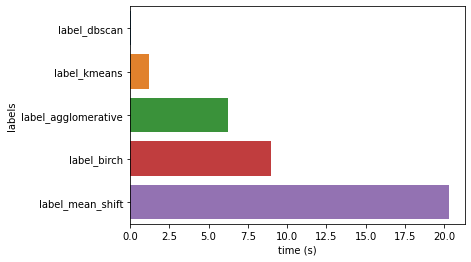

In [24]:
# Etiquetas de los algoritmos que hemos usado
labels = ["label_kmeans", "label_dbscan", "label_birch", "label_mean_shift", "label_agglomerative"]

# Tomamos los tiempos de ejecucion
times = [global_metrics[label]["ellapsed_time (s)"] for label in labels]

# Ordenamos las dos listas basandonos en la de tiempos, para obtener una mejor visualizacion
times, labels = zip(*sorted(zip(times, labels)))

# Creamos un dataframe para mostrar usando seaborn
df_sns = pd.DataFrame()
df_sns["labels"] = labels
df_sns["time (s)"] = times

# Mostramos la grafica buscada
sns.barplot(data = df_sns, x = "time (s)", y = "labels")

Veamos ahora el número de clusters que han generado los algoritmos:

<AxesSubplot:xlabel='total_clusters', ylabel='labels'>

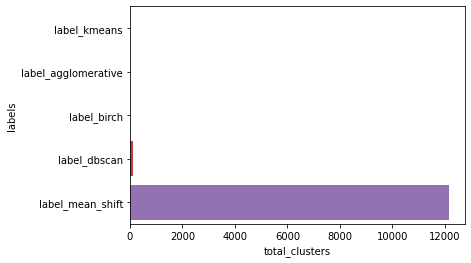

In [25]:
# Tomamos el numero de clusters
num_clusters = [global_metrics[label]["total_clusters"] for label in labels]

# Ordenamos las dos listas basandonos en la de numero de clusters, para obtener una mejor visualizacion
num_clusters, labels = zip(*sorted(zip(num_clusters, labels)))

# Creamos un dataframe para mostrar usando seaborn
df_sns = pd.DataFrame()
df_sns["labels"] = labels
df_sns["total_clusters"] = num_clusters

# Mostramos la grafica buscada
sns.barplot(data = df_sns, x = "total_clusters", y = "labels")

Comparamos ahora los índices de Silhouette, que recordemos que queremos que sean lo más cercano a 1:

<AxesSubplot:xlabel='silhouette', ylabel='labels'>

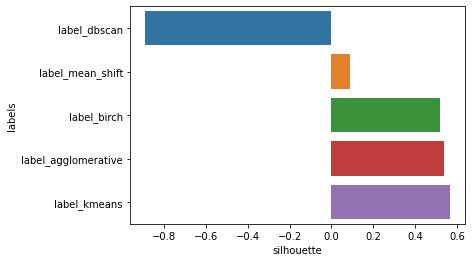

In [26]:
silhouette = [global_metrics[label]["silhouette"] for label in labels]
silhouette, labels = zip(*sorted(zip(silhouette, labels)))

# Creamos un dataframe para mostrar usando seaborn
df_sns = pd.DataFrame()
df_sns["labels"] = labels
df_sns["silhouette"] = silhouette

# Mostramos la grafica buscada
sns.barplot(data = df_sns, x = "silhouette", y = "labels")

Hacemos lo mismo con Calinski:

<AxesSubplot:xlabel='calinski', ylabel='labels'>

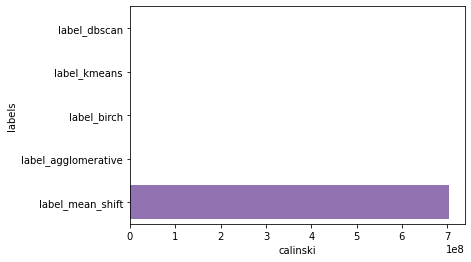

In [27]:
calinski = [global_metrics[label]["calinski"] for label in labels]
calinski, labels = zip(*sorted(zip(calinski, labels)))

# Creamos un dataframe para mostrar usando seaborn
df_sns = pd.DataFrame()
df_sns["labels"] = labels
df_sns["calinski"] = calinski

# Mostramos la grafica buscada
sns.barplot(data = df_sns, x = "calinski", y = "labels")

Hacemos lo mismo con Davies:

<AxesSubplot:xlabel='davies', ylabel='labels'>

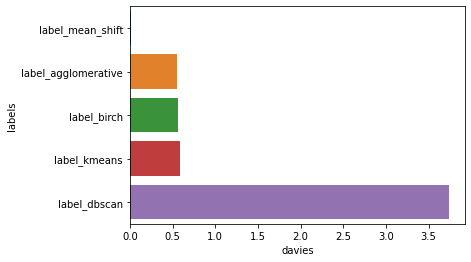

In [28]:
davies = [global_metrics[label]["davies"] for label in labels]
davies, labels = zip(*sorted(zip(davies, labels)))

# Creamos un dataframe para mostrar usando seaborn
df_sns = pd.DataFrame()
df_sns["labels"] = labels
df_sns["davies"] = davies

# Mostramos la grafica buscada
sns.barplot(data = df_sns, x = "davies", y = "labels")

Y veamos ahora las dos estadísticas sobre el número de elementos por cada cluster:

<!-- TODO -- juntar estas dos graficas en una sola -->

<AxesSubplot:xlabel='elements_mean', ylabel='labels'>

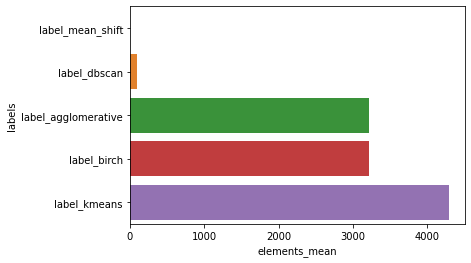

In [29]:
elements_mean = [global_metrics[label]["elements_mean"] for label in labels]
elements_mean, labels = zip(*sorted(zip(elements_mean, labels)))

# Creamos un dataframe para mostrar usando seaborn
df_sns = pd.DataFrame()
df_sns["labels"] = labels
df_sns["elements_mean"] = elements_mean

# Mostramos la grafica buscada
sns.barplot(data = df_sns, x = "elements_mean", y = "labels")

<AxesSubplot:xlabel='elements_std', ylabel='labels'>

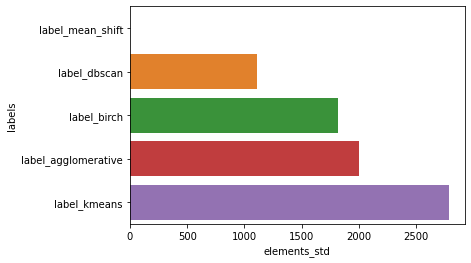

In [30]:
elements_std = [global_metrics[label]["elements_std"] for label in labels]
elements_std, labels = zip(*sorted(zip(elements_std, labels)))

# Creamos un dataframe para mostrar usando seaborn
df_sns = pd.DataFrame()
df_sns["labels"] = labels
df_sns["elements_std"] = elements_std

# Mostramos la grafica buscada
sns.barplot(data = df_sns, x = "elements_std", y = "labels")

## Visualizando en 2D la clusterización

Usamos una técnica como `PCA` para reducir el conjunto de datos multidimensional a tener tan solo 2 dimensiones. A partir de aquí, mostramos gráficamente la clusterización que hemos realizado con cada uno de los algoritmos:

In [31]:
# Reducimos la dimensionalidad del conjunto de datos
pca = PCA(2)

# Reducimos la dimensionalidad
df_lowdimension = pd.DataFrame(pca.fit_transform(df_raw))

# Renombramos las columnas
df_lowdimension = df_lowdimension.rename(columns = {
    0: "first_axis",
    1: "second_axis"
})

Grafico usando las etiquetas de label_mean_shift


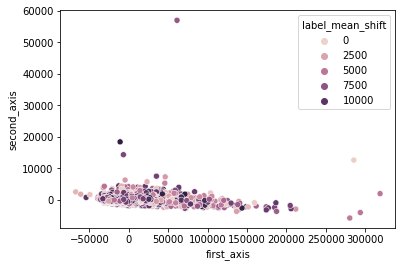

Grafico usando las etiquetas de label_dbscan


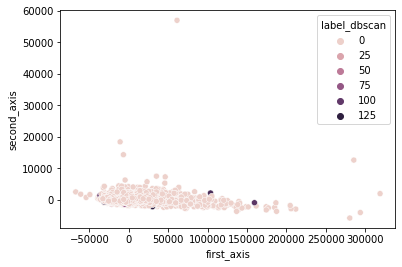

Grafico usando las etiquetas de label_birch


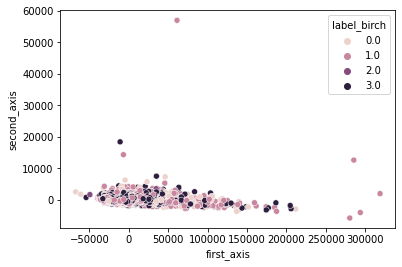

Grafico usando las etiquetas de label_agglomerative


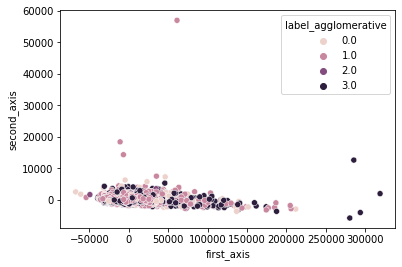

Grafico usando las etiquetas de label_kmeans


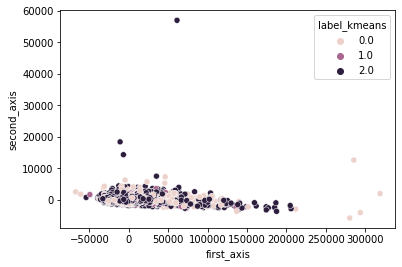

In [32]:
# Por cada algoritmo, mostramos la clusterizacion realizada
for label in labels:
    print(f"Grafico usando las etiquetas de {label}")
    sns.scatterplot(data = df_lowdimension, x = "first_axis", y = "second_axis", hue = df_first[label])
    plt.show()

Realizamos lo mismo pero usando `TSNE` como algoritmo para reducir la dimensionalidad:

In [33]:
# Reducimos la dimensionalidad
df_lowdimension = pd.DataFrame(TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(df_raw))

# Renombramos las columnas
df_lowdimension = df_lowdimension.rename(columns = {
    0: "first_axis",
    1: "second_axis"
})

Grafico usando las etiquetas de label_mean_shift


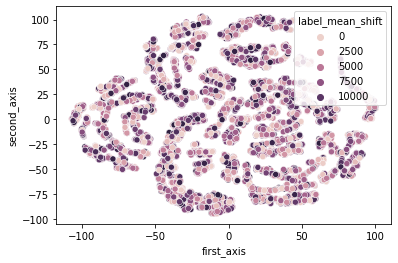

Grafico usando las etiquetas de label_dbscan


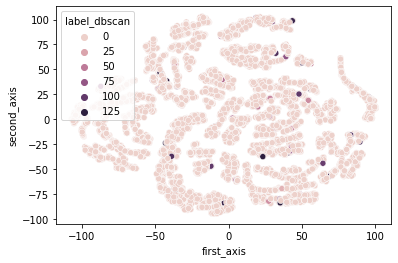

Grafico usando las etiquetas de label_birch


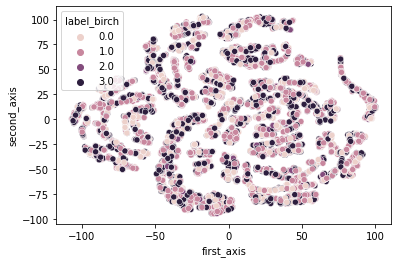

Grafico usando las etiquetas de label_agglomerative


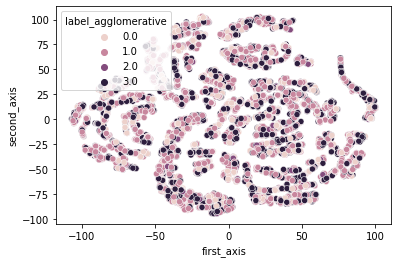

Grafico usando las etiquetas de label_kmeans


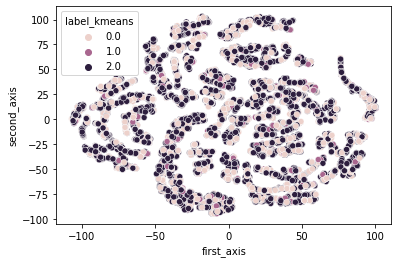

In [34]:
# Por cada algoritmo, mostramos la clusterizacion realizada
for label in labels:
    print(f"Grafico usando las etiquetas de {label}")
    sns.scatterplot(data = df_lowdimension, x = "first_axis", y = "second_axis", hue = df_first[label])
    plt.show()